<a href="https://colab.research.google.com/github/aufzienj/CIS519_final_project/blob/main/519Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import json
pd.set_option('max_colwidth', 4000)

In [ ]:
keywords = pd.read_csv("drive/MyDrive/cis519projectfiles/keywords.csv")
keywords["keywords"]=keywords["keywords"].apply(lambda x:eval(x))
y = keywords.explode("keywords")
y = y.dropna()
h = y['keywords'].apply(pd.Series)
h = h[["name"]]
h['movie_id'] = h.index
g = h
g = g.reset_index()
keyword_movie_id = g[["name", "movie_id"]]

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
keyword_movie_id['compound'] = [analyzer.polarity_scores(x)['compound'] for x in keyword_movie_id['name']]
keyword_movie_id['neg'] = [analyzer.polarity_scores(x)['neg'] for x in keyword_movie_id['name']]
keyword_movie_id['neu'] = [analyzer.polarity_scores(x)['neu'] for x in keyword_movie_id['name']]
keyword_movie_id['pos'] = [analyzer.polarity_scores(x)['pos'] for x in keyword_movie_id['name']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
keyword_movie_id = keyword_movie_id.groupby('movie_id').mean()
keyword_movie_id['movie_id'] = keyword_movie_id.index
keyword_movie_id = keyword_movie_id.reset_index(drop=True)

In [ ]:
credits = pd.read_csv("drive/MyDrive/cis519projectfiles/credits.csv")
credits["cast"]=credits["cast"].apply(lambda x:eval(x))
credits_cast = credits.explode("cast")
credits_cast = credits_cast['cast'].apply(pd.Series)
credits_cast = credits_cast[["name"]]
credits_cast['movie_id'] = credits_cast.index

In [ ]:
distinct_actors = credits_cast['name']
distinct_actors =distinct_actors.drop_duplicates()
distinct_actors = distinct_actors.to_frame()
distinct_actors = distinct_actors.select_dtypes(include=['object'])
distinct_actors = distinct_actors.dropna(subset=['name'])
distinct_actors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202747 entries, 0 to 45474
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name    202747 non-null  object
dtypes: object(1)
memory usage: 3.1+ MB


In [ ]:
metadata = pd.read_csv("drive/MyDrive/cis519projectfiles/movies_metadata.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
from ast import literal_eval
def fix_genres(x):
    genres = []
    for i in x:
        genres.append(list(i.values())[1])

    return genres

metadata['genresx'] = metadata['genres'].fillna('[]').apply(literal_eval).apply(lambda x: fix_genres(x))

In [ ]:
import pandas as pd
# ["2883",	"7759",	"7760",	"7761",	"11176",	"11602",	"17161",	"18012",	"18013",	"23822",	"29812",	"33751",	"Action",	"Adventure",	"Animation",	"Comedy",	"Crime", "Documentary",	"Drama",	"Family",	"Fantasy",	"Foreign",	"History",	"Horror",	"Music",	"Mystery",	"Romance",	"Science Fiction",	"TV Movie",	"Thriller",	"War", 	"Western"]
genres_exploded = pd.get_dummies(metadata['genresx'].explode()).sum(level=0)

In [ ]:
metadata = metadata.join(genres_exploded, how='outer')
metadata = metadata.drop(columns = ['genres', 'genresx'])

In [ ]:
def fix_prod_countries(x):
    countries = []
    for i in x:
        countries.append(list(i.values())[1])

    return countries

metadata['production_countries'] = metadata['production_countries'].replace('6.0', '[]')
metadata['production_countries'] = metadata['production_countries'].replace('7.0', '[]')
metadata['production_countries'] = metadata['production_countries'].replace('4.3', '[]')
metadata['production_countriesx'] = metadata['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: fix_prod_countries(x))

In [ ]:
production_countries = pd.get_dummies(metadata['production_countriesx'].explode()).sum(level=0)
metadata = metadata.join(production_countries, how='outer')
metadata = metadata.drop(columns=["production_countries", "production_countriesx"])

In [ ]:
def fix_languages(x):
    langs = []
    for i in x:
        langs.append(list(i.values())[1])

    return langs

metadata['spoken_languagesx'] = metadata['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: fix_languages(x))

In [ ]:
languages = pd.get_dummies(metadata['spoken_languagesx'].explode()).sum(level=0)
metadata = metadata[metadata.id != '1997-08-20']
metadata = metadata.join(languages, how='outer')
metadata = metadata.drop(columns=["spoken_languagesx", "spoken_languages"])
metadata = metadata.drop(columns=["belongs_to_collection", "homepage", "original_title", "poster_path", "production_companies", "overview", "tagline", "title"])
metadata = pd.get_dummies(metadata, columns=["adult", "original_language", "status", "video" ])

In [ ]:
import datetime
metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce',format='%Y-%m-%d')
metadata['budget'] = metadata['budget'].replace('/ff9qCepilowshEtG2GYWwzt2bs4.jpg', 0)
metadata['budget'] = metadata['budget'].replace('/zaSf5OG7V8X8gqFvly88zDdRm46.jpg', 0)
metadata['release_date'] = pd.to_datetime(metadata['release_date'])
metadata = metadata.dropna()
metadata['year'] = pd.DatetimeIndex(metadata['release_date']).year
metadata['id']=metadata['id'].astype(int)
metadata = metadata.merge(keyword_movie_id, left_on="id", right_on="movie_id", how="inner")
metadata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,budget,id,imdb_id,popularity,release_date,revenue,runtime,vote_average,vote_count,2883,7759,7760,7761,11176,11602,17161,18012,18013,23822,29812,33751,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,...,original_language_qu,original_language_ro,original_language_ru,original_language_rw,original_language_sh,original_language_si,original_language_sk,original_language_sl,original_language_sm,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored,video_False,video_True,year,compound,neg,neu,pos,movie_id
0,65000000,8844,tt0113497,17.0155,1995-12-15,262797249.0,104.0,6.9,2413.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1995,-0.220020,0.400000,0.600000,0.000000,8844
1,0,15602,tt0113228,11.7129,1995-12-22,0.0,101.0,6.5,92.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1995,0.000000,0.000000,1.000000,0.000000,15602
2,16000000,31357,tt0114885,3.85949,1995-12-22,81452156.0,127.0,6.1,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1995,-0.131675,0.250000,0.750000,0.000000,31357
3,0,11862,tt0113041,8.38752,1995-02-10,76578911.0,106.0,5.7,173.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1995,0.020450,0.126000,0.741333,0.132667,11862
4,60000000,949,tt0113277,17.9249,1995-12-15,187436818.0,170.0,7.7,1886.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1995,0.059146,0.093846,0.690154,0.216000,949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13185,0,44330,tt0135690,0.21926,1905-01-01,0.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1905,0.068000,0.000000,0.858800,0.141200,44330
13186,0,44333,tt0135179,0.208349,1905-01-01,0.0,3.0,6.1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1905,0.148043,0.000000,0.697000,0.303000,44333
13187,0,44324,tt0135631,0.213973,1904-03-05,0.0,3.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1904,-0.005160,0.100000,0.900000,0.000000,44324
13188,0,14885,tt0457437,2.568495,2005-09-13,0.0,67.0,5.4,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
metadata = metadata.loc[metadata['revenue'] != 0]

In [ ]:
metadata = metadata.merge(credits_cast, left_on="id", right_on="movie_id", how="inner")

In [ ]:
cast_count = metadata.groupby('name').count()
cast_count = cast_count.sort_values(by=['budget'])
cast_count = cast_count[cast_count['budget'] != 1]
cast_count = cast_count.reset_index()
cast_count = cast_count['name']
cast_count

0              Archie Hahn
1              Jerry Mayer
2            Jessie Arnold
3              Jon Pertwee
4              Akira Nakao
               ...        
9492         Dennis Hopper
9493       Whoopi Goldberg
9494    Christopher Walken
9495     Samuel L. Jackson
9496          Bess Flowers
Name: name, Length: 9497, dtype: object

In [ ]:
metadata = metadata.merge(cast_count, left_on="name", right_on="name", how="inner")

In [ ]:
just_cast = metadata["name"]
just_cast = just_cast.drop_duplicates()

In [ ]:
just_cast = just_cast.reset_index()
just_cast = just_cast.drop(columns=["index"])
just_cast

,name
0,Henry Thomas
1,Dabney Coleman
2,Michael Murphy
3,Christina Nigra
4,John McIntire
...,...
9492,David Alan Basche
9493,Conleth Hill
9494,David Wald
9495,Paul Drechsler-Martell


In [ ]:
# !pip install selenium
# !apt-get update # to update ubuntu to correctly run apt install
# !apt install chromium-chromedriver
# !cp /usr/lib/chromium-browser/chromedriver /usr/bin
# import sys
# !pip install webdriver-manager

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.support import expected_conditions as EC
# import os
# import time

# chrome_options = webdriver.ChromeOptions()
# chrome_options.add_argument('--headless')
# chrome_options.add_argument('--no-sandbox')
# chrome_options.add_argument('--disable-dev-shm-usage')
# driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

In [ ]:
# def launch_selenium(driver, name):
#     # Launch the web broswer and navigate to an actor's wikipedia page
#     # Returns start year from "years active"
    
#     url = 'https://en.wikipedia.org/wiki/' + name    

#     driver.get(url)
#     # print(driver.page_source)
#     try: 
    
#       years = driver.find_element_by_xpath('//table[@class="infobox biography vcard"]/tbody/tr[th/text()="Years\u00A0active"]/td').text 
#       years = years.split("–")
#       return years[0]
#     except:
#       return "0"
    
    

In [ ]:
# year = []

In [ ]:
# for index, value in just_cast.items():
#   year.append(launch_selenium(driver, value))
# year

In [ ]:
# print(len(year))

In [ ]:
# df = pd.DataFrame(year) 
    
# # saving the dataframe 
# df.to_csv('years.csv') 

In [ ]:
# button = driver.find_element_by_xpath('//button[@class="button-textsignin-button-text"]')
# button.click()

In [ ]:
# graph_div = driver.find_element_by_id('ranking_graph')
# location = graph_div.find_elements_by_tag_name('rect')[1:]
# name = (driver.find_elements_by_class_name('display-name')[1]
#               .find_element_by_tag_name('a')
#               .text)

# star_meter_data = []
# for i in range(1, len(location)+1):
#     loc = graph_div.find_elements_by_tag_name('rect')[i]
#     (driver.find_element_by_class_name('current_rank')
#             .find_element_by_tag_name('span')
#            .click())
#         try:
#             loc.click()
#         except:
#             time.sleep(0.5)
#         g = graph_div.find_elements_by_tag_name('tspan')[-2:]
#         dates = g[0].text.split('-')
#         start_date = datetime.datetime.strptime(dates[0].strip(), 
#                                                '%b %d, %Y')
#         end_date = datetime.datetime.strptime(dates[1].strip(), 
#                                               '%b %d, %Y')
#         star_meter = int(g[1].text.split(':')[-1]
#                              .strip()
#                              .replace(',',''))
#         star_meter_data.append([i, name_id, 
                                # name, start_date, 
                                # end_date, star_meter])

In [ ]:
actor_years_active = pd.read_csv("drive/MyDrive/cis519projectfiles/years.csv")

In [ ]:
actor_years_active = actor_years_active.drop(columns = ["Unnamed: 0"])

In [ ]:
actor_years_active = pd.concat([actor_years_active, just_cast], axis=1)

In [ ]:
actor_years_active['start_year_active'] = actor_years_active['0']
actor_years_active = actor_years_active.drop(columns=["0"])
actor_years_active

,name,start_year_active
0,Henry Thomas,1981
1,Dabney Coleman,1961
2,Michael Murphy,0
3,Christina Nigra,1981—1992
4,John McIntire,1932
...,...,...
9492,David Alan Basche,1997-present
9493,Conleth Hill,1986
9494,David Wald,0
9495,Paul Drechsler-Martell,0


In [ ]:
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("–") == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("-") == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("—") == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains(",") == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("c.\u20091940") == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("c.\u20091982") == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("muician") == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("muian") == False]

actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['s'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['from '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['Actor: '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['\[2\]'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['\[1\] '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['\[1\]'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['Stage '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['\n....'], value='')
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.match('990[{}]') == False]
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("p") == False]
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['; ....'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['ca. '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['\n1937'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['−....'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['Actor \('], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['c. '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['Stage: '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=[' to 1962'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['c.'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['early '], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['/02'], value='')
actor_years_active["start_year_active"] = actor_years_active["start_year_active"].replace(regex=['Bodybuilding \('], value='')



In [ ]:
actor_years_active = actor_years_active[actor_years_active["start_year_active"].str.contains("muian") == False]

In [ ]:
dataset = metadata.merge(actor_years_active, left_on="name", right_on="name", how="inner")

In [ ]:
dataset = dataset.astype({"start_year_active": int})

In [ ]:
dataset["time_before"] = dataset["year"] - dataset["start_year_active"]

In [ ]:
dataset.loc[dataset['time_before'] > 100, 'time_before'] = 0

In [ ]:
dataset.loc[dataset['time_before'] < 0, 'time_before'] = 0

In [ ]:
dataset = dataset.sort_values(by=['movie_id_x'])
dataset = dataset.drop(columns=["name", "start_year_active"])

In [ ]:
l = list(dataset.columns.values)
print(l)

['budget', 'id', 'imdb_id', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average', 'vote_count', 2883, 7759, 7760, 7761, 11176, 11602, 17161, 18012, 18013, 23822, 29812, 33751, 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Chad', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica', "Cote D'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Czechoslovakia', 'Denmark', 'Dominican Republic', 'East Germany', 'Ecuador', 'Egypt', 'E

In [ ]:
l.remove('time_before')
print(l)

['budget', 'id', 'imdb_id', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average', 'vote_count', 2883, 7759, 7760, 7761, 11176, 11602, 17161, 18012, 18013, 23822, 29812, 33751, 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antarctica', 'Argentina', 'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands', 'Chad', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica', "Cote D'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'Czechoslovakia', 'Denmark', 'Dominican Republic', 'East Germany', 'Ecuador', 'Egypt', 'E

In [ ]:
dataset = dataset.groupby(l)['time_before'].sum().reset_index()
dataset

,budget,id,imdb_id,popularity,release_date,revenue,runtime,vote_average,vote_count,2883,7759,7760,7761,11176,11602,17161,18012,18013,23822,29812,33751,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,...,original_language_ru,original_language_rw,original_language_sh,original_language_si,original_language_sk,original_language_sl,original_language_sm,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored,video_False,video_True,year,compound,neg,neu,pos,movie_id_x,movie_id_y,time_before
0,0,6,tt0107286,5.53867,1993-10-15,12136938.0,110.0,6.4,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1993,0.000000,0.000000,1.000000,0.000000,6,6,331
1,0,20,tt0314412,10.3105,2003-03-07,9726954.0,106.0,7.2,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2003,-0.105611,0.222222,0.748056,0.029722,20,20,323
2,0,67,tt0445620,3.71419,2005-02-14,3357075.0,90.0,6.9,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2005,0.106150,0.000000,0.865333,0.134667,67,67,81
3,0,113,tt0374546,8.15789,2003-09-19,6502364.0,103.0,7.6,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2003,0.162520,0.000000,0.800000,0.200000,113,113,115
4,0,145,tt0115751,8.55869,1996-05-13,3803298.0,159.0,7.2,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1996,0.063640,0.000000,0.893000,0.107000,145,145,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,95000000,10501,tt0138749,8.75519,2000-03-31,76432727.0,89.0,7.0,892.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2000,0.000000,0.000000,1.000000,0.000000,10501,10501,301
3437,967686,37495,tt1341167,11.934,2010-05-07,4270000.0,101.0,7.1,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2010,0.000000,0.000000,1.000000,0.000000,37495,37495,50
3438,970000,18710,tt0072761,3.66954,1975-04-16,2000000.0,101.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1975,0.000000,0.000000,1.000000,0.000000,18710,18710,24
3439,98000000,1408,tt0112760,7.28448,1995-12-22,10017322.0,119.0,5.7,137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
dataset = dataset.drop(columns=["movie_id_x", "movie_id_y"])

In [ ]:
import numpy as np
from scipy import stats
dataset = dataset[(np.abs(stats.zscore(dataset['revenue']))<4)] 
dataset = dataset[(np.abs(stats.zscore(dataset['runtime']))<6)] 

dataset

,budget,id,imdb_id,popularity,release_date,revenue,runtime,vote_average,vote_count,2883,7759,7760,7761,11176,11602,17161,18012,18013,23822,29812,33751,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,...,original_language_qu,original_language_ro,original_language_ru,original_language_rw,original_language_sh,original_language_si,original_language_sk,original_language_sl,original_language_sm,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored,video_False,video_True,year,compound,neg,neu,pos,time_before
0,0,6,tt0107286,5.53867,1993-10-15,12136938.0,110.0,6.4,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1993,0.000000,0.000000,1.000000,0.000000,331
1,0,20,tt0314412,10.3105,2003-03-07,9726954.0,106.0,7.2,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2003,-0.105611,0.222222,0.748056,0.029722,323
2,0,67,tt0445620,3.71419,2005-02-14,3357075.0,90.0,6.9,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2005,0.106150,0.000000,0.865333,0.134667,81
3,0,113,tt0374546,8.15789,2003-09-19,6502364.0,103.0,7.6,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2003,0.162520,0.000000,0.800000,0.200000,115
4,0,145,tt0115751,8.55869,1996-05-13,3803298.0,159.0,7.2,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1996,0.063640,0.000000,0.893000,0.107000,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,95000000,10501,tt0138749,8.75519,2000-03-31,76432727.0,89.0,7.0,892.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2000,0.000000,0.000000,1.000000,0.000000,301
3437,967686,37495,tt1341167,11.934,2010-05-07,4270000.0,101.0,7.1,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2010,0.000000,0.000000,1.000000,0.000000,50
3438,970000,18710,tt0072761,3.66954,1975-04-16,2000000.0,101.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1975,0.000000,0.000000,1.000000,0.000000,24
3439,98000000,1408,tt0112760,7.28448,1995-12-22,10017322.0,119.0,5.7,137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
mean_col = np.asarray(dataset['budget'], dtype=np.float).mean()
print(mean_col)

22727127.26951399


In [ ]:
dataset['budget']= dataset['budget'].astype(np.float).replace(0, mean_col)

In [ ]:
dataset

,budget,id,imdb_id,popularity,release_date,revenue,runtime,vote_average,vote_count,2883,7759,7760,7761,11176,11602,17161,18012,18013,23822,29812,33751,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,...,original_language_qu,original_language_ro,original_language_ru,original_language_rw,original_language_sh,original_language_si,original_language_sk,original_language_sl,original_language_sm,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored,video_False,video_True,year,compound,neg,neu,pos,time_before
0,2.272713e+07,6,tt0107286,5.53867,1993-10-15,12136938.0,110.0,6.4,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1993,0.000000,0.000000,1.000000,0.000000,331
1,2.272713e+07,20,tt0314412,10.3105,2003-03-07,9726954.0,106.0,7.2,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2003,-0.105611,0.222222,0.748056,0.029722,323
2,2.272713e+07,67,tt0445620,3.71419,2005-02-14,3357075.0,90.0,6.9,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2005,0.106150,0.000000,0.865333,0.134667,81
3,2.272713e+07,113,tt0374546,8.15789,2003-09-19,6502364.0,103.0,7.6,240.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2003,0.162520,0.000000,0.800000,0.200000,115
4,2.272713e+07,145,tt0115751,8.55869,1996-05-13,3803298.0,159.0,7.2,213.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1996,0.063640,0.000000,0.893000,0.107000,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3436,9.500000e+07,10501,tt0138749,8.75519,2000-03-31,76432727.0,89.0,7.0,892.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2000,0.000000,0.000000,1.000000,0.000000,301
3437,9.676860e+05,37495,tt1341167,11.934,2010-05-07,4270000.0,101.0,7.1,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,2010,0.000000,0.000000,1.000000,0.000000,50
3438,9.700000e+05,18710,tt0072761,3.66954,1975-04-16,2000000.0,101.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1975,0.000000,0.000000,1.000000,0.000000,24
3439,9.800000e+07,1408,tt0112760,7.28448,1995-12-22,10017322.0,119.0,5.7,137.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
f = dataset[dataset['time_before']<0] 
f

,budget,id,imdb_id,popularity,release_date,revenue,runtime,vote_average,vote_count,2883,7759,7760,7761,11176,11602,17161,18012,18013,23822,29812,33751,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,...,original_language_qu,original_language_ro,original_language_ru,original_language_rw,original_language_sh,original_language_si,original_language_sk,original_language_sl,original_language_sm,original_language_sq,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_tg,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,status_Canceled,status_In Production,status_Planned,status_Post Production,status_Released,status_Rumored,video_False,video_True,year,compound,neg,neu,pos,time_before


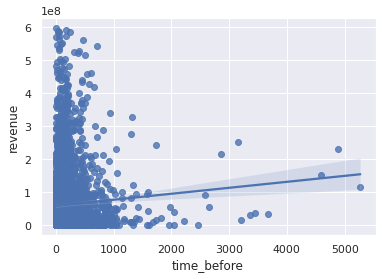

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_theme(color_codes=True)

ax = sns.regplot(x="time_before", y="revenue", data=dataset)

In [ ]:
# START MACHINE LEARNING SECTION

In [ ]:
y = dataset['revenue']
X = dataset.drop(columns = ['revenue', 'id', 'imdb_id','release_date'])

y_old = y.drop(columns = ['compound', 'neg', 'neu', 'pos', 'time_before'])
X_old = X.drop(columns = ['compound', 'neg', 'neu', 'pos', 'time_before'])

In [ ]:
X_old.columns

Index([                'budget',             'popularity',
                      'runtime',           'vote_average',
                   'vote_count',                     2883,
                           7759,                     7760,
                           7761,                    11176,
       ...
         'original_language_zu',        'status_Canceled',
         'status_In Production',         'status_Planned',
       'status_Post Production',        'status_Released',
               'status_Rumored',            'video_False',
                   'video_True',                   'year'],
      dtype='object', length=376)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostRegressor
import sklearn

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size = .33, random_state = 42)
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_old,y_old , test_size = .33, random_state = 42)

#knn model
knn_model = KNeighborsClassifier(n_neighbors= 100, p = 2)
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)
knn_mse = mean_squared_error(y_test, knn_y_pred)
knn_r2 = r2_score(y_test, knn_y_pred)

print(knn_mse)
print(knn_r2)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


1.1808835974719794e+16
-0.3748828020970836


In [ ]:
#linear regression model
lin_reg_model = linear_model.LinearRegression()
lin_reg_model.fit(X_train, y_train)
lin_y_pred = lin_reg_model.predict(X_test)
lin_mse = mean_squared_error(y_test, lin_y_pred)
lin_r2 = r2_score(y_test, lin_y_pred)

print(lin_mse)
print(lin_r2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


3058698018478411.5
0.6438809624066962


In [ ]:
# #logistic regression model
# scaler        = StandardScaler()
# X_train       = scaler.fit_transform(X_train)
# X_test        = scaler.transform(X_test)

# log_reg_model = linear_model.LogisticRegression(solver = 'saga', max_iter=800, penalty='l2', C=0.1)
# log_reg_model.fit(X_train, y_train)
# log_y_pred = log_reg_model.predict(X_test)
# log_mse = mean_squared_error(y_test, log_y_pred)
# log_r2 = r2_score(y_test, log_y_pred)


# print(log_mse)
# print(log_r2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

model 1:
3315743994620360.5
0.6139535341061936


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


1557047504470537.2
0.8187155922457022


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


2861644447298916.0
0.6668235764532031


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


1632658829505260.5
0.8099122935415316


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


927492759832790.2
0.8920135864962827


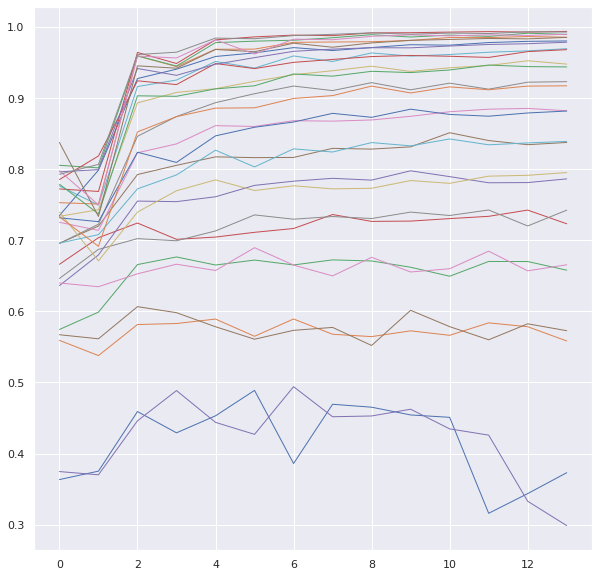

In [ ]:
r2_array_depth = []
r2_old_array_depth = []

for i in range(1,15):
  r2_array = []
  r2_old_array = []
  for j in range(1,15):
    regr1 = AdaBoostRegressor(base_estimator = sklearn.tree.DecisionTreeRegressor(max_depth=i), n_estimators=j)
    regr1.fit(X, y)
    regr1_y_pred = regr1.predict(X_test)
    regr1_mse = mean_squared_error(y_test, regr1_y_pred)
    regr1_r2 = r2_score(y_test, regr1_y_pred)


    regr1_old = AdaBoostRegressor(base_estimator = sklearn.tree.DecisionTreeRegressor(max_depth=i), n_estimators=j)
    regr1_old.fit(X_old, y_old)
    regr1_y_pred_old = regr1_old.predict(X_test_old)
    regr1_mse_old = mean_squared_error(y_test_old, regr1_y_pred_old)
    regr1_r2_old = r2_score(y_test_old, regr1_y_pred_old)


    #print(i)
    #print(j)

    r2_array.append(regr1_r2)
    r2_old_array.append(regr1_r2_old)

    # print(regr1_mse)
    # print(regr1_r2)
    # print(regr1_mse_old)
    # print(regr1_r2_old)

  r2_array_depth.append(r2_array)
  r2_old_array_depth.append(r2_old_array)

# print(r2_array_depth)
# print(r2_old_array_depth)

plt.figure(figsize=(10,10))

for a in range(len(r2_array_depth)):
  plt.plot(range(len(r2_array_depth[a])), r2_array_depth[a], linewidth=1, label=" With Scraped Data, Tree Depth = %d"%a)
for b in range(len(r2_old_array_depth)):
  plt.plot(range(len(r2_old_array_depth[b])), r2_old_array_depth[b], linewidth=1, label="No Scraped Data, Tree Depth = %d"%a)

regr1 = AdaBoostRegressor(base_estimator = linear_model.LinearRegression(), n_estimators=5)
regr1.fit(X, y)
regr1_y_pred = regr1.predict(X_test)
regr1_mse = mean_squared_error(y_test, regr1_y_pred)
regr1_r2 = r2_score(y_test, regr1_y_pred)

print('model 1:')
print(regr1_mse)
print(regr1_r2)

regr1 = AdaBoostRegressor(base_estimator = sklearn.tree.DecisionTreeRegressor(max_depth=6), n_estimators=5)
regr1.fit(X, y)
regr1_y_pred = regr1.predict(X_test)
regr1_mse = mean_squared_error(y_test, regr1_y_pred)
regr1_r2 = r2_score(y_test, regr1_y_pred)
print(regr1_mse)
print(regr1_r2)

regr1_old = AdaBoostRegressor(n_estimators=6)
regr1_old.fit(X_old, y_old)
regr1_y_pred_old = regr1_old.predict(X_test_old)
regr1_mse_old = mean_squared_error(y_test_old, regr1_y_pred_old)
regr1_r2_old = r2_score(y_test_old, regr1_y_pred_old)

print(regr1_mse_old)
print(regr1_r2_old)

regr1_old = AdaBoostRegressor(base_estimator = sklearn.tree.DecisionTreeRegressor(max_depth=6), n_estimators=5)
regr1_old.fit(X_old, y_old)
regr1_y_pred_old = regr1_old.predict(X_test_old)
regr1_mse_old = mean_squared_error(y_test_old, regr1_y_pred_old)
regr1_r2_old = r2_score(y_test_old, regr1_y_pred_old)

print(regr1_mse_old)
print(regr1_r2_old)

regr1_old = AdaBoostRegressor(base_estimator = sklearn.tree.DecisionTreeRegressor(max_depth=8), n_estimators=5)
regr1_old.fit(X_old, y_old)
regr1_y_pred_old = regr1_old.predict(X_test_old)
regr1_mse_old = mean_squared_error(y_test_old, regr1_y_pred_old)
regr1_r2_old = r2_score(y_test_old, regr1_y_pred_old)

print(regr1_mse_old)
print(regr1_r2_old)

In [ ]:
regr1_old = AdaBoostRegressor(base_estimator = sklearn.tree.DecisionTreeRegressor(max_depth=12), n_estimators=10)
regr1_old.fit(X_old, y_old)
regr1_y_pred_old = regr1_old.predict(X_test_old)
regr1_mse_old = mean_squared_error(y_test_old, regr1_y_pred_old)
regr1_r2_old = r2_score(y_test_old, regr1_y_pred_old)

print(regr1_mse_old)
print(regr1_r2_old)


estimators_list = regr1_old.estimators_


regr2 = AdaBoostRegressor(n_estimators=20, learning_rate=0.001)
regr2.fit(X, y)
regr2_y_pred = regr2.predict(X_test)
regr2_mse = mean_squared_error(y_test, regr2_y_pred)
regr2_r2 = r2_score(y_test, regr2_y_pred)

print('model 2:')
print(regr2_mse)
print(regr2_r2)

regr2_old = AdaBoostRegressor(n_estimators=20, learning_rate=0.001)
regr2_old.fit(X_old, y_old)
regr2_y_pred_old = regr2_old.predict(X_test_old)
regr2_mse_old = mean_squared_error(y_test_old, regr2_y_pred_old)
regr2_r2_old = r2_score(y_test_old, regr2_y_pred_old)

print(regr2_mse_old)
print(regr2_r2_old)

# regr3 = AdaBoostRegressor(n_estimators=4)
# regr3.fit(X, y)
# regr3_y_pred = regr3.predict(X_test)
# regr3_mse = mean_squared_error(y_test, regr3_y_pred)
# regr3_r2 = r2_score(y_test, regr3_y_pred)

# print(regr3_mse)
# print(regr3_r2)

In [ ]:
# Visualize the tree
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
!pip install dtreeviz
from dtreeviz.trees import dtreeviz # remember to load the package


for x in estimators_list:
  # #first visualization method
  # text_representation = tree.export_text(x)
  # # print(text_representation)

  #second visualization method
  fig = plt.figure(figsize=(25,20))
  plt.rc('axes', unicode_minus=False)
  _ = tree.plot_tree(x, feature_names=X_old.columns, filled=True) 